# COVID-19 Tracker
Using data on COVID-19 from the European Centre for Disease Control (via the website ourworldindata.org), and world population data from the World Bank, and the Python programming language and Jupyter (IPython) Notebook, I generated some charts to help visualize the data. You can skim the code below, and jumpt to the bottom to see the summary charts.

I have made this source code available as open source on the code sharing service GitHub (see https://github.com/bakirl/covid19-tracker) . You can also launch a Jupyter notebook live in your browser using the service called binder (see https://mybinder.org/v2/gh/bakirl/covid19-tracker/master) - this will take a few minutes to launch, after which you can click on the file (covid19.ipynb). Using this code, you can change things such as the countries and range of dates, etc.

## The Code

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from datetime import datetime

In [2]:
# filter warnings, for now!
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download latest Covid 19 data
world_df = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")
# df.date is a string, convert to a datetime object
world_df['date'] = [datetime.strptime(date, '%Y-%m-%d') for date in world_df.date]

# Downloaded population from World Bank
# http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv
pop_df = pd.read_csv("population.csv", skiprows=4)
pop_df = pop_df.set_index('Country Name')
pop_df = pop_df['2018'].dropna()

In [4]:
# Default values
values_def = 'new_cases'
start_def = '2020-03-01'
end_def = '2066-05-08' # i.e. no end date (way in the future)
#countries_def=['Italy','Spain','United Kingdom','Ireland','China','United States','Iran']
countries_def=[]

# Set the default size for the figures
plt.rcParams["figure.figsize"] = (14, 10)

In [5]:
# generate a pivot of values for a specified list of countries for a specified range of dates
# @param df - data frame containing Covid 19 data by date and by country
# @param pop - data frome containing population data from 2018
# @param values - one of 'new cases', 'total cases', 'new deaths', total deaths'
# @param start - show data only for dates since this date; format 'yyyy-mm-dd'
# @param locations - show data only for the specified locations
# @param by_pop - set to True to divide numbers by population per country, in 100K
def covid(df=world_df, pop=pop_df, values=values_def, start=start_def, end=end_def,
          locations=countries_def, by_pop=False, sort=True, world_strip=True):
    # filter by date
    df2 = df[df.date >= start]
    df2 = df2[df.date <= end]
    # generate a pivot chart
    piv = df2.pivot(index='date', columns='location', values=values)
    # filter by country
    if (locations == []):
        if (world_strip):
            sub = piv.drop(columns='World')
        else:
            sub = piv
    else:
        sub = piv[locations]
    # setup title of plot
    title=values + " from " + start
    if (by_pop):
        # divide each number by the population, in 100K
        if (locations == []):
            pop2=pop
        else:
            pop2 = pop[locations]
        pop2 = pop2/1e5
        #pop2 = pop2.transpose()
        #sub = sub/pop2.values
        sub = sub/pop2
        title = title + " per 100K of population"
    if (sort):
        # sort based on highest value on the most recent date (last row)
        lastrow = sub.shape[0]-1
        lastrow_name = sub.index[lastrow]
        sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
    return sub, title

In [6]:
# generate the sub-pivot for all countries in the covid dataframe
sub, title = covid(locations=[])

# not all countries in the covid dataframe are also in the population dataframe
# find the intersection of these two sets
countries_inter_index = pop_df.index.intersection(sub.columns)
countries_inter = countries_inter_index.values

In [7]:
# Countries with smaller populations are showing up - let's look at 40 countries with the smallest population
pop2=pop_df[countries_inter].sort_values(ascending=False)
entries=pop2.shape[0]

In [8]:
# Let's only consider countries with population greater than 1m
countries_small = pop2[pop2.values <= 1e6]
countries_large_index = countries_inter_index.difference(countries_small.index)
countries_large = countries_large_index.values

In [9]:
def covid_plot1(df=world_df, pop=pop_df, n=10, locations=countries_inter, by_pop=False, sort=False, suptitle='', 
               start=start_def, end=end_def, normalized=False, rolling_window=7, major=14, sort_after=True, world_strip=True,
              values='new_cases', width=10, height=7, mult=1):
    plt.rcParams["figure.figsize"] = (width, height)
    fig, ax = plt.subplots(1, 1, linewidth=5, edgecolor='black')
    fig.tight_layout(pad=8)
    
    # setup figure title
    if (suptitle==''):
        suptitle = 'Top ' + str(n) + ' Locations'
    if (by_pop):
        suptitle += ', by Population'
    div = "\n"
    if (rolling_window != 1):
        suptitle += div + 'Moving Average over ' + str(rolling_window) + ' days'
        div = ', '
    if (normalized):
        suptitle += div + 'Normalized'
        div = ', '
    if (mult == 1):
        suptitle += ', per day'
    else:
        suptitle += ', per ' + str(mult) + ' days'
    fig.suptitle(suptitle, size=18, weight='bold')
    
    sub, title = covid(df=df, pop=pop, locations=locations, by_pop=by_pop, values=values, sort=sort, 
                       start=start, end=end, world_strip=world_strip)
    # set rolling window
    sub = sub.rolling(window=rolling_window).mean()
    sub = sub * mult
    if (normalized):
        sub = sub/sub.max(axis=0)
    if (sort_after):
        # resort at this point as normalization etc. affects order
        # sort based on highest value on the most recent date (last row)
        lastrow = sub.shape[0]-1
        lastrow_name = sub.index[lastrow]
        sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
    sub = sub.iloc[:, :n]
    ax1 = sub.plot(title=title, logy=False, ax=ax)
    ax1.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5, axis='both')
    ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=major))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%e %b'))
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    if (not normalized):
        ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

In [10]:
values_range_def = ['new_cases', 'total_cases', 'new_deaths', 'total_deaths']
# plot the data from the pivot in 4 charts, on for each of new cases, total cases, new deaths, total deaths
# @param n - show data from the top N countries
# @param locations - show data only for the specified locations
# @param by_pop - set to True to divide numbers by population per country, in 100K
# @param sort - if True, sort countries by highest value on last day
# @param suptitle - title to use for the set of 4 charts
# @param start_def - start date
# @param normalized - if True, normalize all values so that max value per country is 100%
#           Note, this is good for comparing the "shape"/slope of different countries with
#           very different absolute values.
# @param rolling_window - number of days over which to do a moving average
# @param major - major interval (in days) on x axis
def covid_plot4(df=world_df, pop=pop_df, n=10, locations=countries_inter, by_pop=False, sort=False, suptitle='', 
               start=start_def, end=end_def, normalized=False, rolling_window=7, major=14, sort_after=True, world_strip=True,
              values_range=values_range_def):
    plt.rcParams["figure.figsize"] = (14, 10)
    fig, ax = plt.subplots(2, 2, linewidth=5, edgecolor='black')
    fig.tight_layout(pad=8)
    
    # setup figure title
    if (suptitle==''):
        suptitle = 'Top ' + str(n) + ' Locations'
    if (by_pop):
        suptitle += ', by Population'
    div = "\n"
    if (rolling_window != 1):
        suptitle += div + 'Moving Average over ' + str(rolling_window) + ' days'
        div = ', '
    if (normalized):
        suptitle += div + 'Normalized'
        div = ', '
    fig.suptitle(suptitle, size=18, weight='bold')
    
    for values, axis in zip(values_range, [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]):
        sub, title = covid(df=df, pop=pop, locations=locations, by_pop=by_pop, values=values, sort=sort, 
                           start=start, end=end, world_strip=world_strip)
        # set rolling window
        sub = sub.rolling(window=rolling_window).mean()
        if (normalized):
            sub = sub/sub.max(axis=0)
        if (sort_after):
            # resort at this point as normalization etc. affects order
            # sort based on highest value on the most recent date (last row)
            lastrow = sub.shape[0]-1
            lastrow_name = sub.index[lastrow]
            sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
        sub = sub.iloc[:, :n]
        ax1 = sub.plot(title=title, logy=False, ax=axis)
        ax1.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5, axis='both')
        ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax1.xaxis.set_major_locator(mdates.DayLocator(interval=major))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%e %b'))
        for tick in ax1.get_xticklabels():
            tick.set_rotation(45)
        if (not normalized):
            ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}')) 

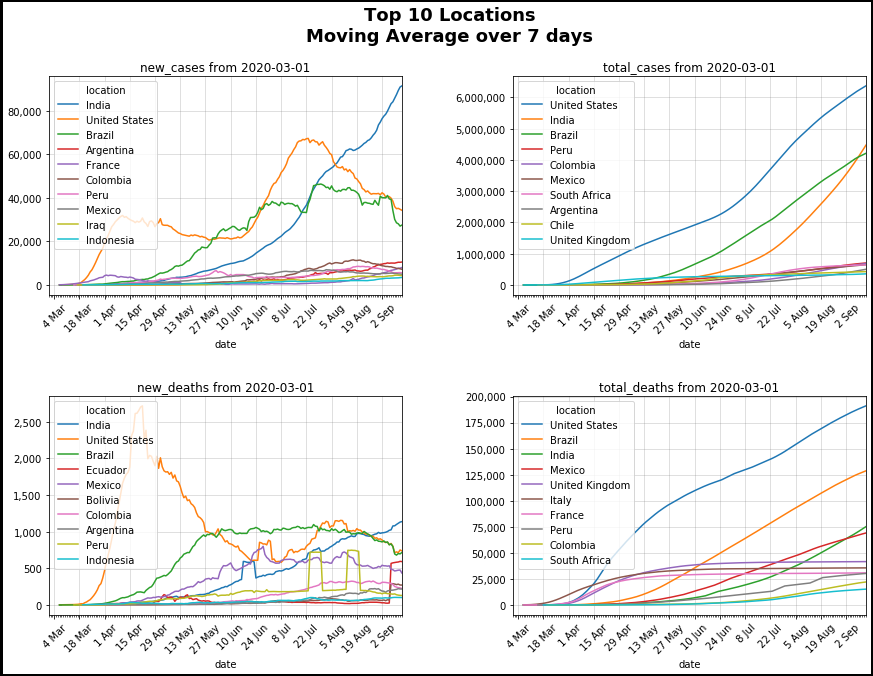

In [11]:
covid_plot4(rolling_window=7)

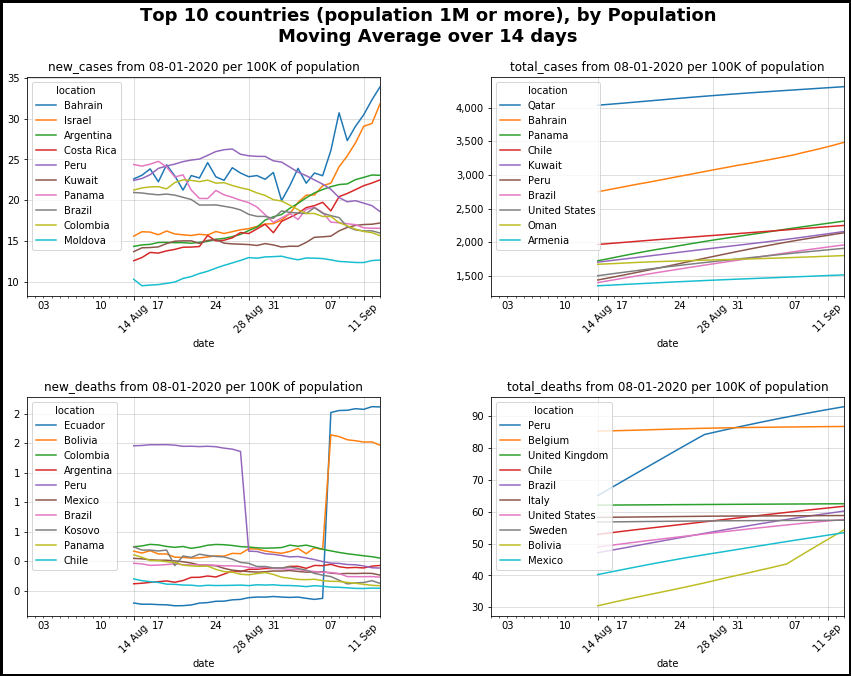

In [12]:
# when sorting by population, exclude smaller countries
covid_plot4(by_pop=True, locations=countries_large, suptitle="Top 10 countries (population 1M or more)", 
           start='08-01-2020', rolling_window=14)

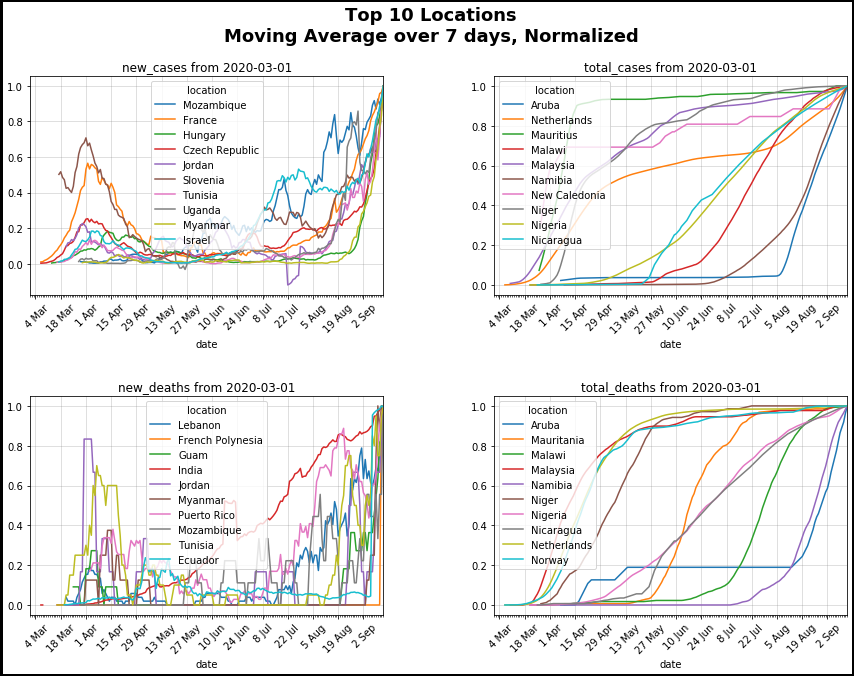

In [13]:
covid_plot4(normalized=True)

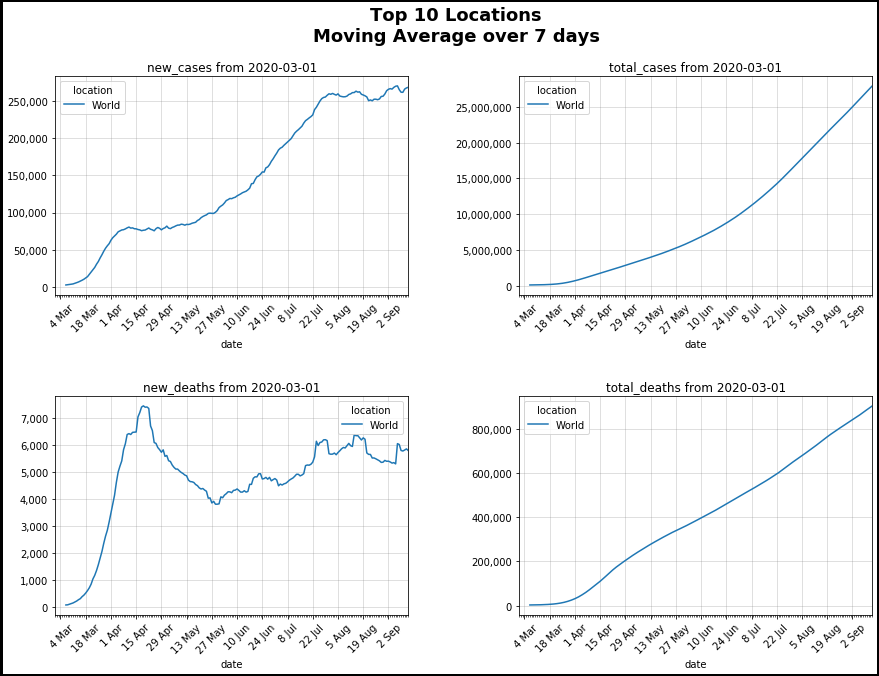

In [14]:
covid_plot4(locations=['World'])

In [15]:
# US data by state
us_df = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
us_df.rename(columns={'state': 'location', 'cases': 'total_cases', 'deaths': 'total_deaths'}, inplace=True)
us_df.drop(columns='fips', inplace=True)
# add new columns for new cases and deaths and populate by calculating diff over the corresponding totals
us_df['new_cases'] = 0
us_df['new_deaths'] = 0
for location in us_df.location.unique():
    us_df.loc[us_df.location == location, ['new_cases']] = us_df[us_df.location == location]['total_cases'].diff()
    us_df.loc[us_df.location == location, ['new_deaths']] = us_df[us_df.location == location]['total_deaths'].diff()
# df.date is a string, convert to a datetime object
us_df['date'] = [datetime.strptime(date, '%Y-%m-%d') for date in us_df.date]

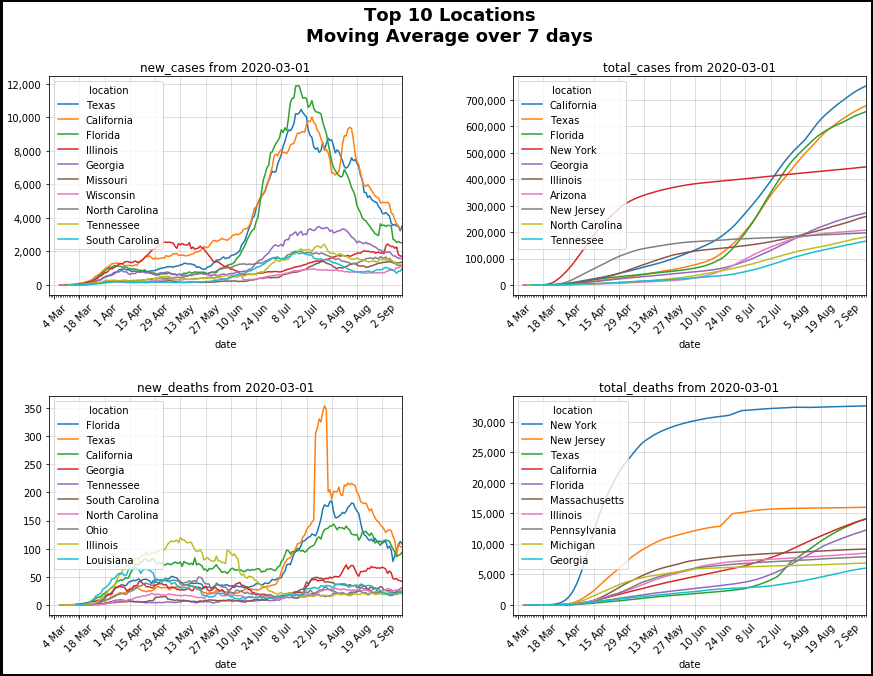

In [16]:
covid_plot4(df=us_df, locations=[], rolling_window=7, world_strip=False)

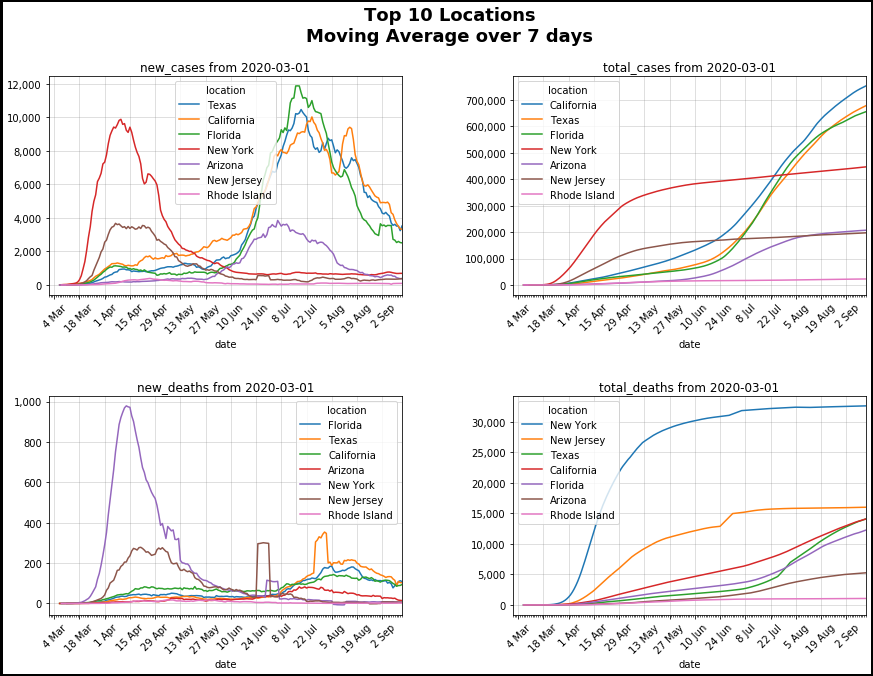

In [17]:
covid_plot4(df=us_df, locations=['Florida', 'Texas', 'California', 'New York', 'Arizona', 'New Jersey', 'Rhode Island'], 
           sort_after=True, rolling_window=7)

In [18]:
# Ireland data by county
ie_df = pd.read_csv("https://opendata.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D")

ie_df.rename(columns={'CountyName': 'location', 'ConfirmedCovidCases': 'total_cases', 'ConfirmedCovidDeaths': 'total_deaths'}, inplace=True)
ie_df.drop(columns=['OBJECTID', 'ORIGID', 'IGEasting', 'IGNorthing', 'Lat', 'Long'], inplace=True)
ie_df.drop(columns=['UGI', 'PopulationProportionCovidCases', 'ConfirmedCovidRecovered', 'Shape__Area', 'Shape__Length'], inplace=True)
# add new columns for new cases and deaths and populate by calculating diff over the corresponding totals
ie_df['new_cases'] = 0
ie_df['new_deaths'] = 0
for location in ie_df.location.unique():
    ie_df.loc[ie_df.location == location, ['new_cases']] = ie_df[ie_df.location == location]['total_cases'].diff()
    ie_df.loc[ie_df.location == location, ['new_deaths']] = ie_df[ie_df.location == location]['total_deaths'].diff()
# df.TimeStamp is a string, convert to a datetime object
ie_df['date'] = ''
ie_df['date'] = [datetime.strptime(date[:10], '%Y/%m/%d') for date in ie_df.TimeStamp]
ie_df.drop(columns=['TimeStamp'], inplace=True)

In [19]:
# Turns out there's a duplicate set of rows on 29 June for some reason, 
# which prevents us from generating a pivot table.
# There's also a missing date (30 Jun); just removing the duplicate
# causes an issue with setting the "locators" on the axis.
# Instead, we change date on second 29 Jun data points to 30 Jun.
from datetime import timedelta

prev_date=datetime.today()
for location in ie_df.location.unique():
    for date in ie_df[ie_df.location==location].date:
        if (date==prev_date):
            # print(f"Duplicate: location={location}, date={str(date)[:10]}")
            next_date = date+timedelta(days=1)
        prev_date = date

# next date should be 30 Jun
# next_date

# set max_rows to None (default 10) to see all rows
# pd.set_option('display.max_rows', None)
# ie_df[ie_df.date=='2020-06-30']

#ie_df = ie_df.drop_duplicates(['location','date'], keep= 'first')
# 
# replace duplicates (29 Jun) with the following date (30 Jun)
ie_df.loc[ie_df.duplicated(['location', 'date']), ['date']] = next_date

In [20]:
# extract population of Ireland by county
ie_pop_df = ie_df[ie_df.date=='2020-06-30'].set_index('location')
ie_pop_df = ie_pop_df['PopulationCensus16']
#ie_pop_df.drop(columns=['total_cases', 'total_deaths', 'new_cases', 'new_deaths', 'date'], inplace=True)

all_counties = ie_df.location.unique()

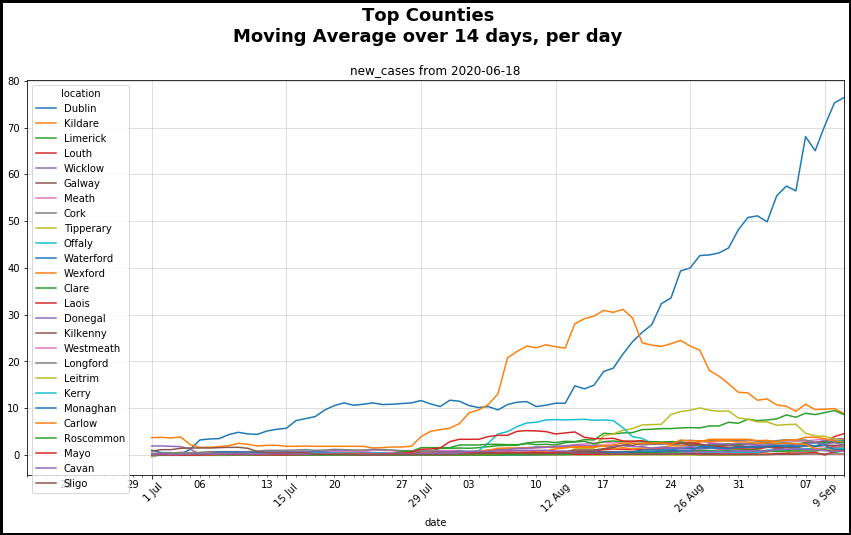

In [21]:
covid_plot1(df=ie_df, pop=ie_pop_df, by_pop=False, locations=[], world_strip=False, 
            start='2020-06-18', rolling_window=14, 
            width=14, height=8, n=26, suptitle='Top Counties')

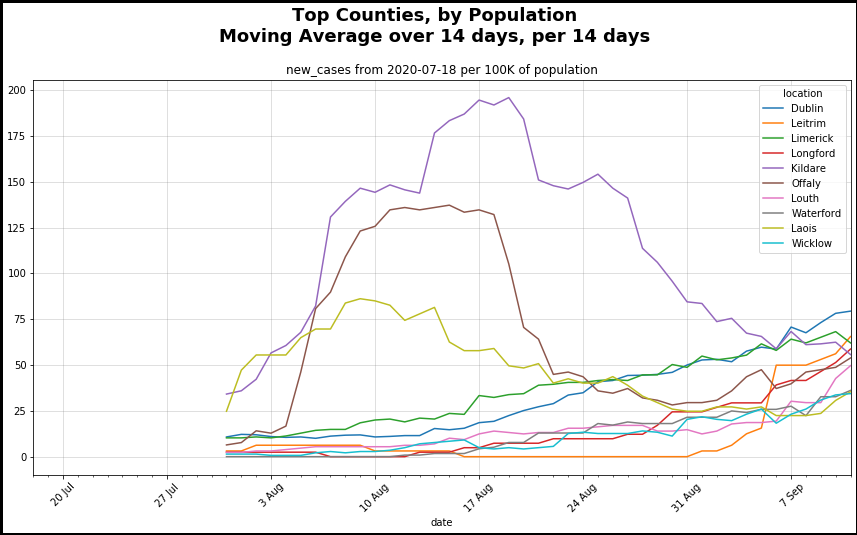

In [25]:
covid_plot1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=[], world_strip=False, 
            start='2020-07-18', rolling_window=14,major=7,
            width=14, height=8, n=10, mult=14, suptitle='Top Counties')

In [23]:
def covid_piv1(df=world_df, pop=pop_df, n=10, locations=countries_inter, by_pop=False, sort=False, suptitle='', 
               start=start_def, normalized=False, rolling_window=7, major=14, sort_after=True, world_strip=True,
              values='new_cases', width=10, height=7, mult=1):
    # setup figure title
    if (suptitle==''):
        suptitle = 'Top ' + str(n) + ' Locations'
    if (by_pop):
        suptitle += ', by Population'
    div = "\n"
    if (rolling_window != 1):
        suptitle += div + 'Moving Average over ' + str(rolling_window) + ' days'
        div = ', '
    if (normalized):
        suptitle += div + 'Normalized'
        div = ', '
    if (mult == 1):
        suptitle += ', per day'
    else:
        suptitle += ', per ' + str(mult) + ' days'
    
    sub, title = covid(df=df, pop=pop, locations=locations, by_pop=by_pop, values=values, sort=sort, 
                       start=start, world_strip=world_strip)
    # set rolling window
    sub = sub.rolling(window=rolling_window).mean()
    sub = sub * mult
    if (normalized):
        sub = sub/sub.max(axis=0)
    if (sort_after):
        # resort at this point as normalization etc. affects order
        # sort based on highest value on the most recent date (last row)
        lastrow = sub.shape[0]-1
        lastrow_name = sub.index[lastrow]
        sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
    sub = sub.iloc[:, :n]
    return sub

In [24]:
piv = covid_piv1(df=ie_df, pop=ie_pop_df, by_pop=True, locations=[], world_strip=False, start='2020-07-18', rolling_window=14, 
                 width=14, height=8, n=26, suptitle='Top Counties', mult=14)
piv.tail(5)

location,Dublin,Leitrim,Limerick,Longford,Kildare,Offaly,Louth,Waterford,Laois,Wicklow,...,Meath,Carlow,Roscommon,Donegal,Galway,Cavan,Kerry,Mayo,Cork,Sligo
date,,,,,,,,,,,,,,,,,,,,,
2020-09-07,70.730963,49.931344,64.135783,41.592249,68.313379,39.763471,30.259768,27.544415,22.432908,23.170090,...,21.533603,56.207405,18.591968,20.729685,13.562842,21.003991,12.186288,4.597455,8.289308,4.577707
2020-09-08,67.613754,49.931344,62.083438,41.592249,61.122497,46.176935,29.483877,22.379837,22.432908,25.978585,...,23.071717,33.373147,18.591968,23.242374,14.337862,21.003991,12.186288,6.129939,6.999860,4.577707
2020-09-09,73.180199,53.052053,65.161956,46.485455,61.571927,47.459627,29.483877,32.708993,23.613587,30.893453,...,24.609832,28.103703,23.239960,20.101513,15.500391,17.065742,12.186288,0.000000,6.263033,4.577707
2020-09-10,78.227109,56.172762,68.240473,51.378661,62.470787,48.742320,42.674032,32.708993,30.697663,33.701948,...,21.533603,22.834258,12.394646,23.242374,17.050431,14.440244,12.186288,8.428667,7.552481,4.577707
2020-09-11,79.414618,65.534890,62.083438,58.718469,55.729335,53.873090,49.657056,36.152045,35.420381,34.404072,...,24.097127,22.834258,18.591968,18.216996,18.212960,15.752993,13.540320,9.194909,7.920894,4.577707
